# MOXSI Mini-X Calibration Tests

In [16]:
import astropy.units as u
import astropy.table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse

from mocksipipeline.instrument.configuration import moxsi_built_filtergrams, moxsi_built

In [17]:
measured_flux = np.load('data/2025-09-24 X-rays 1250ms.npy')#.T[::-1,:]

In [18]:
masked_cmap = plt.get_cmap('viridis')
masked_cmap.set_under('w', alpha=0)
imshow_kwargs = dict(
    origin='lower',
    clim=[1,2.5e4],
    interpolation='none',
    cmap=masked_cmap,
)

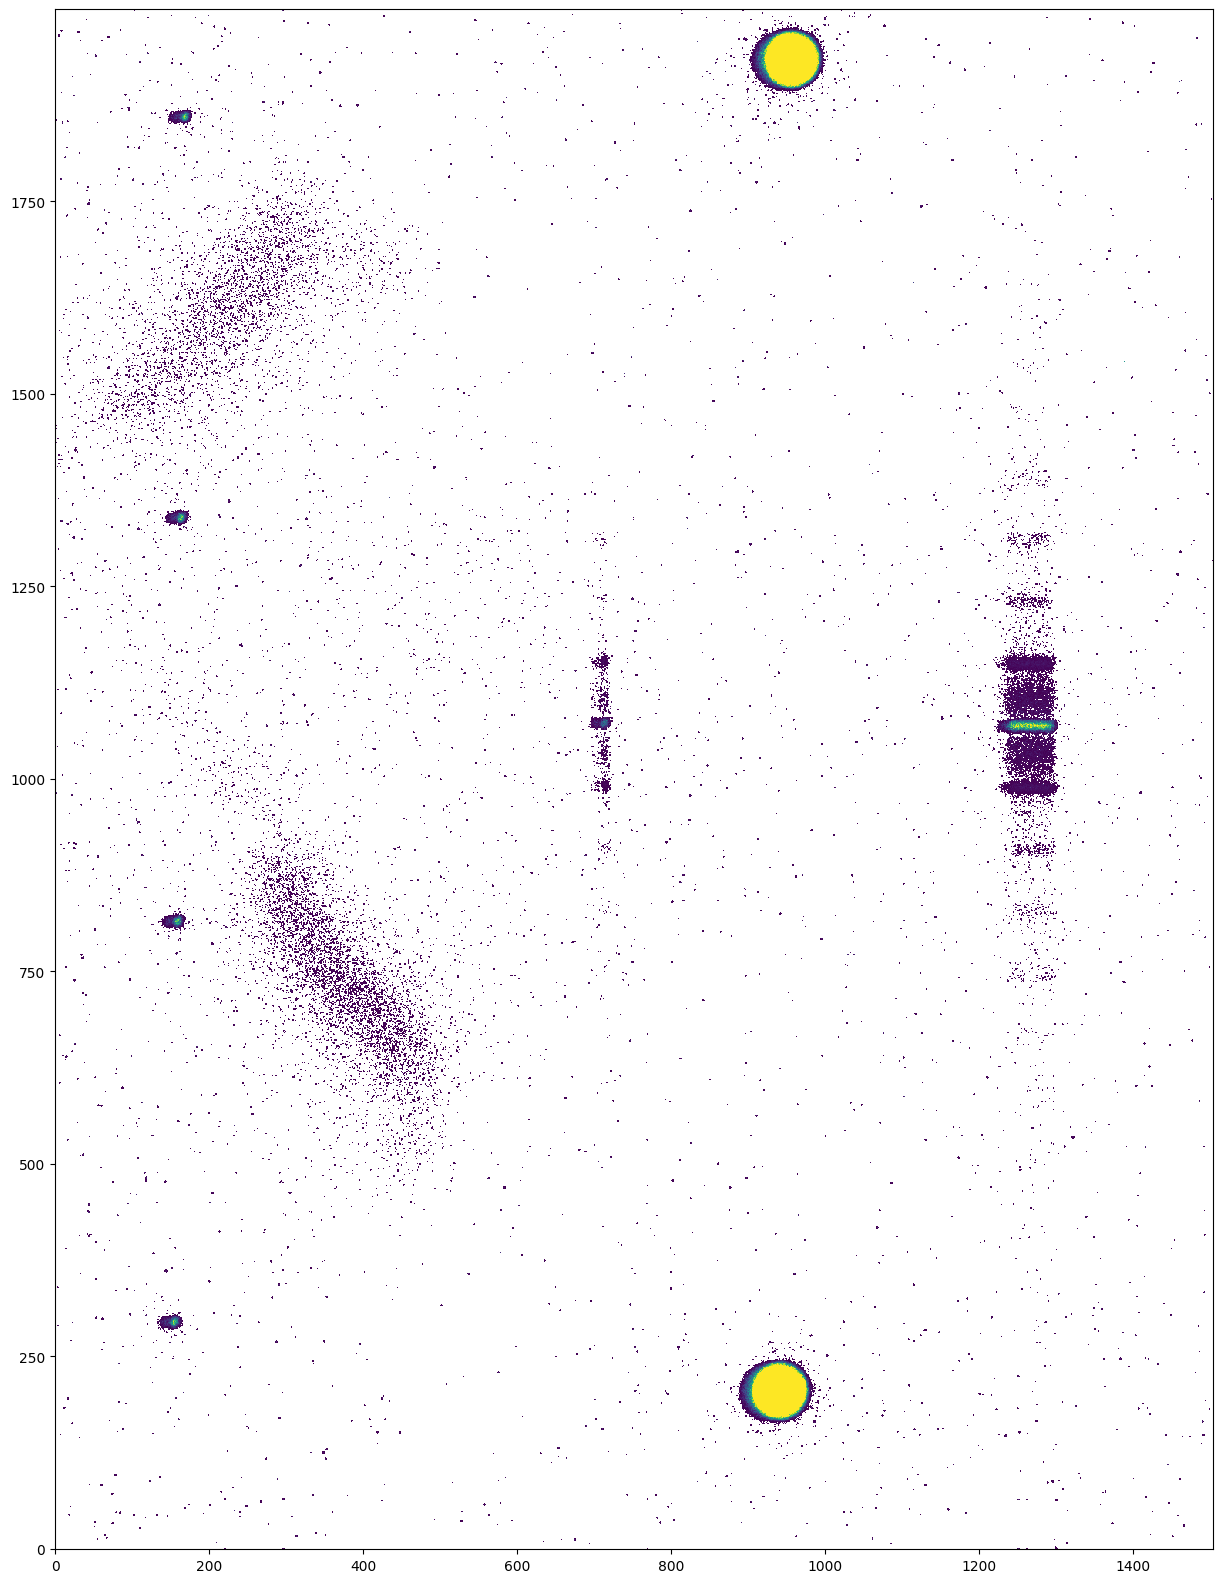

In [19]:
ratio = measured_flux.shape[0]/measured_flux.shape[1]
width = 20
fig = plt.figure(figsize=(width*ratio,width))
ax = fig.add_subplot()
ax.imshow(measured_flux, **imshow_kwargs)

In [20]:
detector_shape = measured_flux.shape
xgrid,ygrid = np.meshgrid(
    np.linspace(0,detector_shape[1]-1, detector_shape[1], dtype=int),
    np.linspace(0,detector_shape[0]-1, detector_shape[0], dtype=int),
)

In [21]:
# I got these numbers by looking at the above image in a matplotlib window and reading
# off the cursor coordinates. These are estimates from the xray flux.
estimated_pinhole_positions = {
    'filtergram_1': (295, 153),#(295, 1349),
    'filtergram_2': (815,159),#(815, 1344),
    'filtergram_3': (1339,163),#(1339, 1340),
    'filtergram_4': (1860,168),#(1859, 1335),
    'spectrogram_pinhole': (1073,712),#(1072, 791),
    'spectrogram_slot': (1069,1266),#(1069, 238),
    'alignment_left': (205,939),#(207, 564),
    'alignment_right': (1935,955),#(1935, 548),
}

In [22]:
detector_width = detector_shape[1]*moxsi_built.optical_design.pixel_size_y
detector_height = detector_shape[0]*moxsi_built.optical_design.pixel_size_x

In [23]:
# These were measured mechanically by Jake from the pinhole plate.
true_pinhole_positions = astropy.table.QTable.read('data/Measured_Flight_Pinhole.csv')
for col in ['x','y','diameter','major','minor']:
    true_pinhole_positions[f'{col} (mm)'].unit = u.mm
true_pinhole_positions['major (mm)'] = np.where(true_pinhole_positions['major (mm)'].mask,
                                                true_pinhole_positions['diameter (mm)'],
                                                true_pinhole_positions['major (mm)'])
true_pinhole_positions['minor (mm)'] = np.where(true_pinhole_positions['minor (mm)'].mask,
                                                true_pinhole_positions['diameter (mm)'],
                                                true_pinhole_positions['minor (mm)'])
true_pinhole_positions['major (mm)'] /= 2
true_pinhole_positions['minor (mm)'] /= 2
true_pinhole_positions.remove_column('diameter (mm)')
true_pinhole_positions.rename_columns(
    true_pinhole_positions.colnames,
    ['name', 'x', 'y', 'major_axis_radius', 'minor_axis_radius']
)
# Apply magnification
true_pinhole_positions['name'] = [
    'alignment_left',
    'alignment_right',
    'spectrogram_slot',
    'spectrogram_pinhole',
    'filtergram_1',
    'filtergram_2',
    'filtergram_3',
    'filtergram_4',
]
# Compute the reference pixel by assuming the spectrogram pinhole is in the center of the detector. Note that I am swapping x and y
# here because the definitions of x and y in the table we read are opposite.
zero_point = true_pinhole_positions[true_pinhole_positions['name']=='spectrogram_pinhole'][['x','y']]
true_pinhole_positions['reference_pixel_x'] = ((true_pinhole_positions['y'] - zero_point['y'])/moxsi_built.optical_design.pixel_size_y + detector_shape[1]/2)*u.pix
true_pinhole_positions['reference_pixel_y'] = ((true_pinhole_positions['x'] - zero_point['x'])/moxsi_built.optical_design.pixel_size_x + detector_shape[0]/2)*u.pix
true_pinhole_positions['reference_pixel_x'] = detector_shape[1]*u.pixel - true_pinhole_positions['reference_pixel_x']
# Note: This flips the vertical orientation of the detector with the assumption being these measurements were made from the opposite side
true_pinhole_positions['reference_pixel_y'] = [
    detector_shape[0]*u.pixel - true_pinhole_positions[true_pinhole_positions['name']=='alignment_left']['reference_pixel_y'][0],
    detector_shape[0]*u.pixel - true_pinhole_positions[true_pinhole_positions['name']=='alignment_right']['reference_pixel_y'][0],
    true_pinhole_positions[true_pinhole_positions['name']=='spectrogram_slot']['reference_pixel_y'][0],
    true_pinhole_positions[true_pinhole_positions['name']=='spectrogram_pinhole']['reference_pixel_y'][0],
    detector_shape[0]*u.pixel - true_pinhole_positions[true_pinhole_positions['name']=='filtergram_1']['reference_pixel_y'][0],
    detector_shape[0]*u.pixel - true_pinhole_positions[true_pinhole_positions['name']=='filtergram_2']['reference_pixel_y'][0],
    detector_shape[0]*u.pixel - true_pinhole_positions[true_pinhole_positions['name']=='filtergram_3']['reference_pixel_y'][0],
    detector_shape[0]*u.pixel - true_pinhole_positions[true_pinhole_positions['name']=='filtergram_4']['reference_pixel_y'][0],
]
# NOTE: This flips the labels appropriately
true_pinhole_positions['name'] = [
    'alignment_right',
    'alignment_left',
    'spectrogram_slot',
    'spectrogram_pinhole',
    'filtergram_4',
    'filtergram_3',
    'filtergram_2',
    'filtergram_1',
]

In [24]:
true_pinhole_positions

name,x,y,major_axis_radius,minor_axis_radius,reference_pixel_x,reference_pixel_y
,mm,mm,mm,mm,pix,pix
str19,float64,float64,float64,float64,float64,float64
alignment_right,66.8373,87.3392,0.21675,0.21675,968.542857142857,1785.7428571428582
alignment_left,77.8385,87.3733,0.21765,0.21765,963.671428571429,214.14285714285847
spectrogram_slot,72.3586,85.3321,0.18615,0.0268,1255.2714285714296,1003.0142857142843
spectrogram_pinhole,72.3375,88.855,0.0221,0.0221,752.0,1000.0
filtergram_4,67.347,92.3437,0.0219,0.0219,253.61428571428655,1712.928571428573
filtergram_3,70.6593,92.3582,0.022,0.022,251.5428571428581,1239.7428571428577
filtergram_2,73.9943,92.371,0.02215,0.02215,249.71428571428692,763.314285714287
filtergram_1,77.3063,92.3825,0.0222,0.0222,248.07142857143026,290.1714285714304


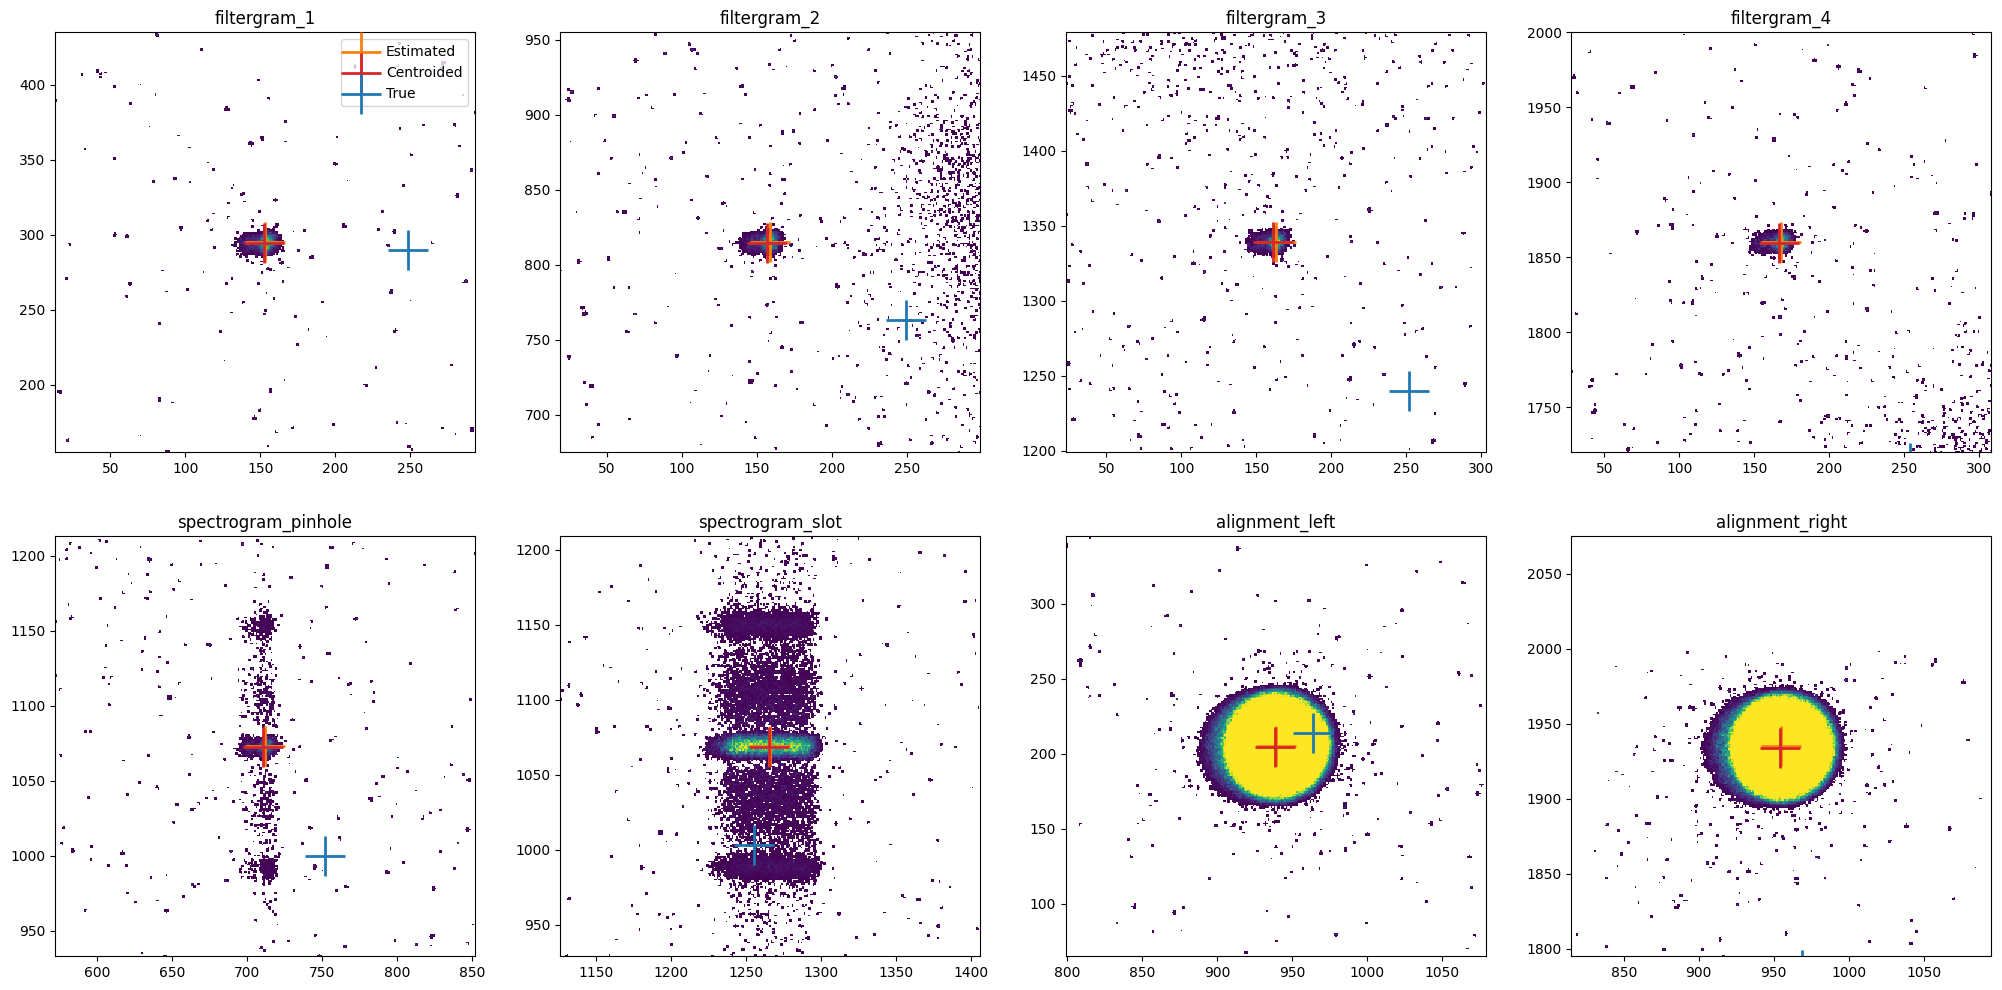

In [25]:
radius = 40
fig = plt.figure(figsize=(25,12))
measured_pinhole_positions = []
for i,k in enumerate(estimated_pinhole_positions):
    y0,x0 = estimated_pinhole_positions[k]
    ix_range = x0-radius,x0+radius
    iy_range = y0-radius,y0+radius
    # Centroiding
    x_centroid, y_centroid = np.average(
        np.array([xgrid[slice(*iy_range),slice(*ix_range)].flatten(),
                  ygrid[slice(*iy_range),slice(*ix_range)].flatten()]),
        axis=1,
        weights=measured_flux[slice(*iy_range),slice(*ix_range)].flatten()
    )
    measured_pinhole_positions.append({'name':k, 'reference_pixel_x': x_centroid, 'reference_pixel_y': y_centroid})
    ## Plot
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(measured_flux, **imshow_kwargs)
    # Plot apparent positions
    ax.scatter(x0, y0, color='C1', marker='+', s=800, lw=2, label='Estimated')
    ax.scatter(x_centroid, y_centroid, color='C3', marker='+', s=800, lw=2, label='Centroided')
    # Plot true positions
    x_true,y_true = true_pinhole_positions[true_pinhole_positions['name']==k][0][['reference_pixel_x','reference_pixel_y']]
    ax.scatter(x_true, y_true, color='C0', marker='+', s=800, lw=2, label='True')
    ax.set_ylim(iy_range+np.array([-100,100]))
    ax.set_xlim(ix_range+np.array([-100,100]))
    ax.set_title(k)
    if i == 0:
        ax.legend()
measured_pinhole_positions = astropy.table.QTable(
    data=measured_pinhole_positions,
    units=[None,'pixel','pixel'],
)

What is the difference between these true and measured pinhole distances?

In [26]:
for row in true_pinhole_positions:
    row_measured = measured_pinhole_positions[measured_pinhole_positions['name']==row['name']][0]
    r = np.sqrt(
        (row['reference_pixel_x'] - row_measured['reference_pixel_x'])**2
        + (row['reference_pixel_y'] - row_measured['reference_pixel_y'])**2
    )
    print(row['name'],r)

alignment_right 148.96242510554734 pix
alignment_left 26.69059773613129 pix
spectrogram_slot 66.52713145648981 pix
spectrogram_pinhole 83.32639473442751 pix
filtergram_4 170.53261544824528 pix
filtergram_3 134.2754649823382 pix
filtergram_2 106.136061881963 pix
filtergram_1 95.71157743507801 pix


(0.0, 2000.0)

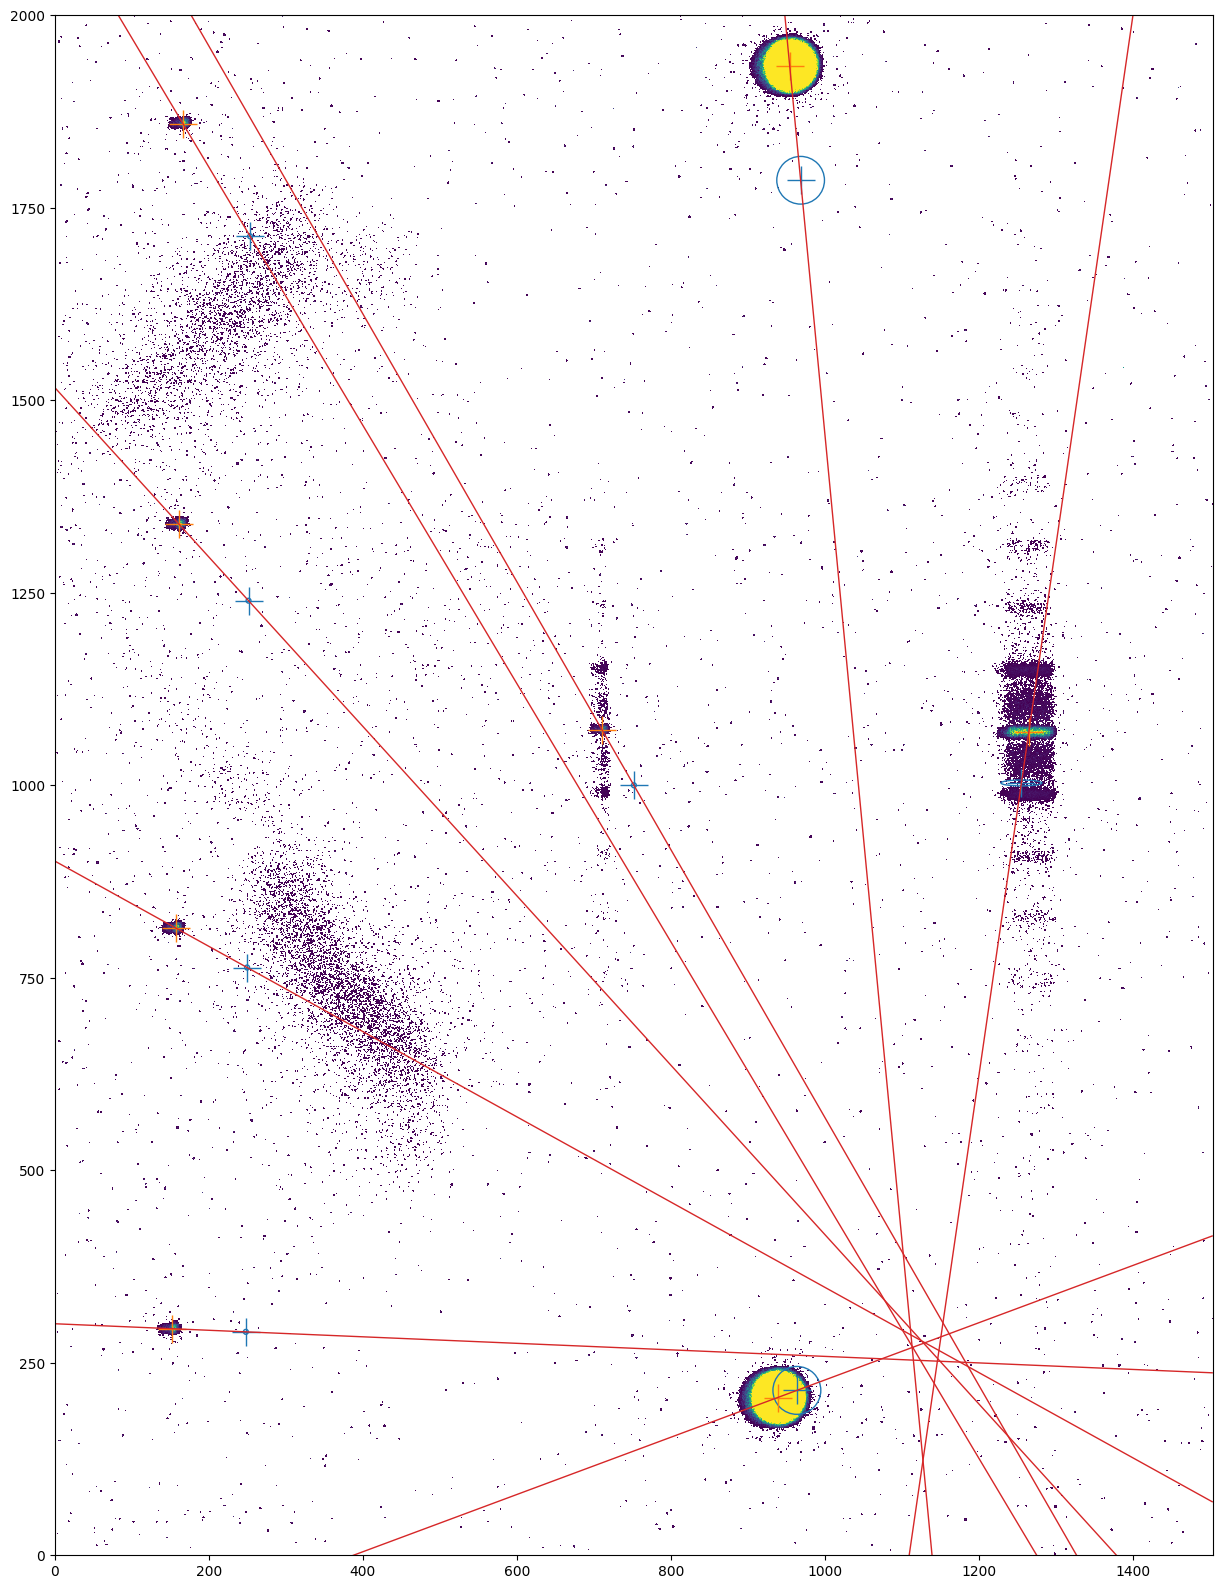

In [27]:
fig = plt.figure(figsize=(width*ratio,width))
ax = fig.add_subplot()
ax.imshow(measured_flux, **imshow_kwargs)
for row in true_pinhole_positions:
    # Plot true center
    ax.plot(row['reference_pixel_x'].to_value('pixel'),
            row['reference_pixel_y'].to_value('pixel'),
            color='C0',marker='+', markersize=20,label='True')
    # Plot true aperture
    aperture = Ellipse(
        (row['reference_pixel_x'].to_value('pix'), row['reference_pixel_y'].to_value('pix')),
        height=2*(row['minor_axis_radius']/moxsi_built.optical_design.pixel_size_x).decompose(),
        width=2*(row['major_axis_radius']/moxsi_built.optical_design.pixel_size_y).decompose(),
        fill=False,
        edgecolor='C0'
    )
    ax.add_patch(aperture)
    # Plot measured centers
    row_measured = measured_pinhole_positions[measured_pinhole_positions['name'] == row['name']][0]
    ax.plot(row_measured['reference_pixel_x'].to_value('pixel'),
            row_measured['reference_pixel_y'].to_value('pixel'),
            color='C1',marker='+',markersize=20,label='Measured')
    # Fit line between two points
    m,b = np.polyfit(
        [row['reference_pixel_x'].to_value('pixel'), row_measured['reference_pixel_x'].to_value('pixel')],
        [row['reference_pixel_y'].to_value('pixel'), row_measured['reference_pixel_y'].to_value('pixel')],
        1
    )
    ray = m*xgrid[0,:] + b
    ax.plot(xgrid[0,:], ray, color='C3', lw=1, ls='-')
ax.set_xlim(0,measured_flux.shape[1])
ax.set_ylim(0,measured_flux.shape[0])

Apply an estimated magnification factor to see if this nudges everything in the correct direction

In [28]:
magnification = 1.1

In [29]:
# Apply magnification
true_pinhole_positions['reference_pixel_x'] *= magnification
true_pinhole_positions['reference_pixel_y'] *= magnification
# Recenter usiung the two spectrogram positions
row_ref = measured_pinhole_positions[measured_pinhole_positions['name']=='spectrogram_pinhole']
row_sph = true_pinhole_positions[true_pinhole_positions['name']=='spectrogram_pinhole']
true_pinhole_positions['reference_pixel_x'] += row_ref['reference_pixel_x'] - row_sph['reference_pixel_x']
true_pinhole_positions['reference_pixel_y'] += row_ref['reference_pixel_y'] - row_sph['reference_pixel_y']

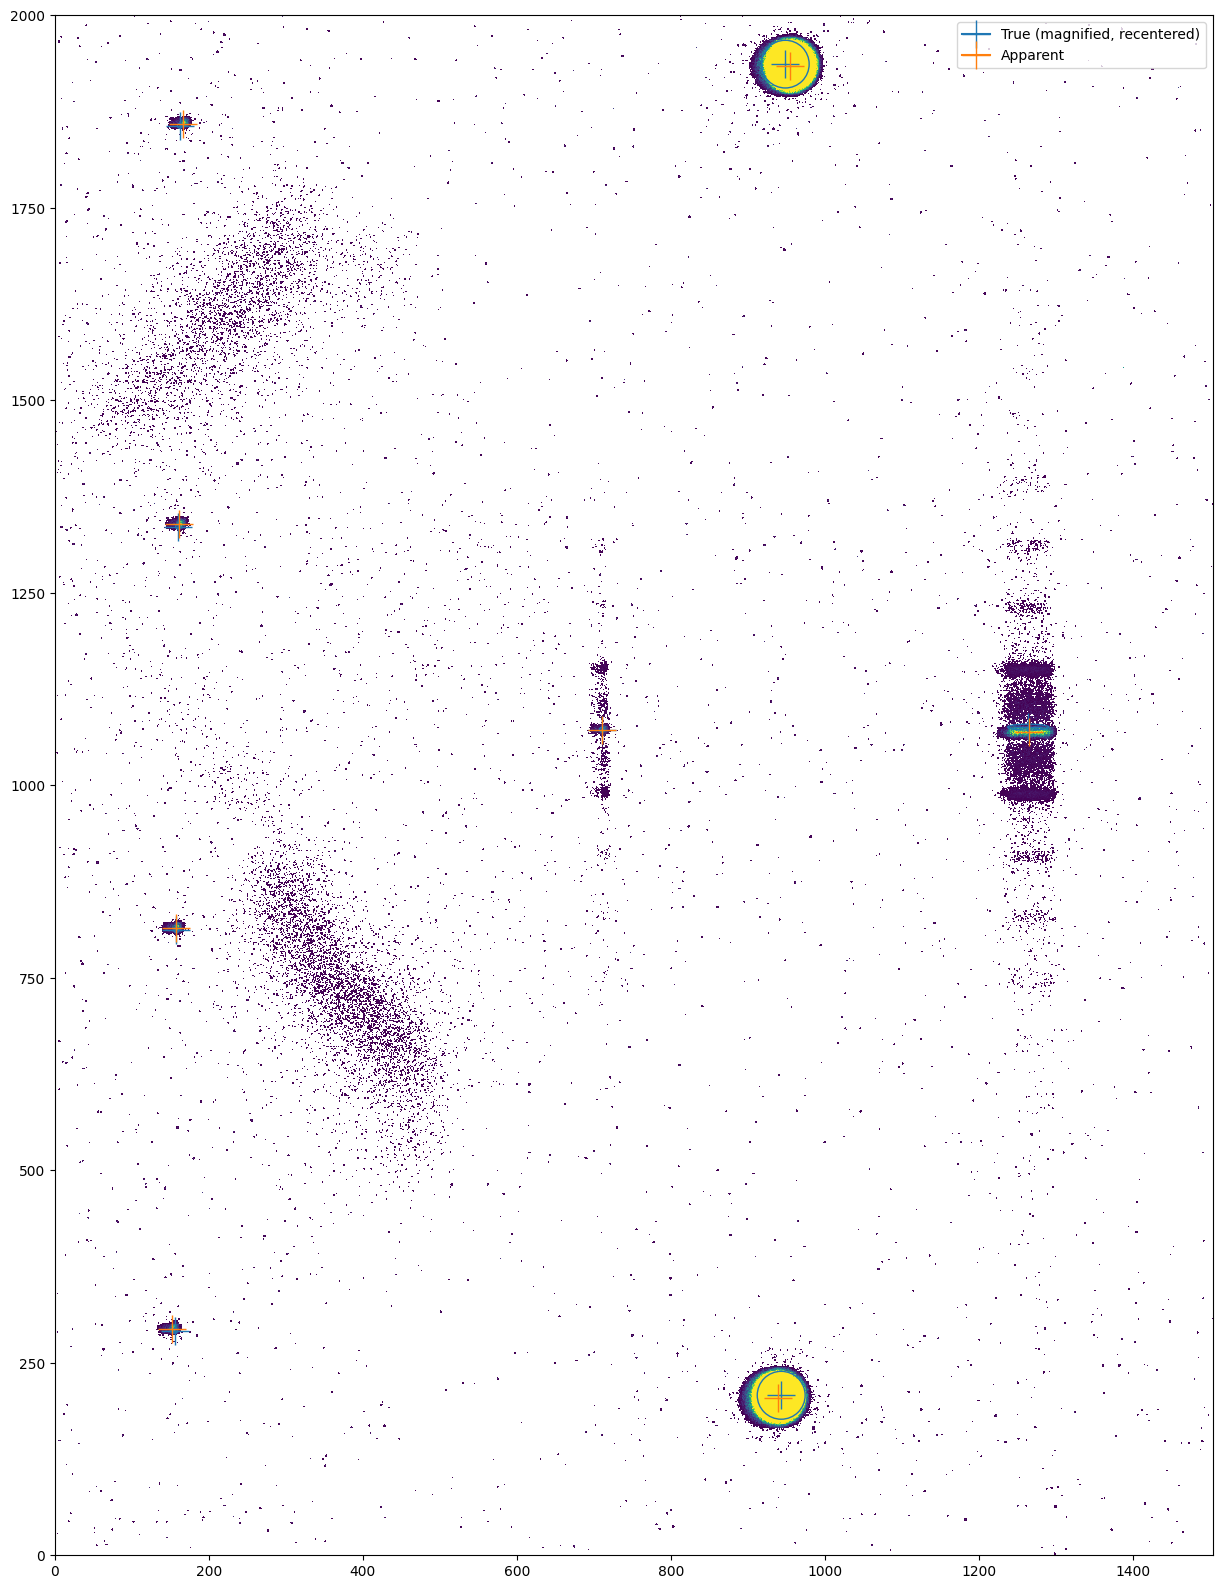

In [34]:
fig = plt.figure(figsize=(width*ratio,width))
ax = fig.add_subplot()
ax.imshow(measured_flux, **imshow_kwargs)
for i,row in enumerate(true_pinhole_positions):
    # Plot true center
    ax.plot(row['reference_pixel_x'].to_value('pixel'),
            row['reference_pixel_y'].to_value('pixel'),
            color='C0',marker='+', markersize=20,label='True (magnified, recentered)' if i==0 else None)
    # Plot true aperture
    aperture = Ellipse(
        (row['reference_pixel_x'].to_value('pix'), row['reference_pixel_y'].to_value('pix')),
        height=2*(row['minor_axis_radius']/moxsi_built.optical_design.pixel_size_x).decompose(),
        width=2*(row['major_axis_radius']/moxsi_built.optical_design.pixel_size_y).decompose(),
        fill=False,
        edgecolor='C0'
    )
    ax.add_patch(aperture)
    # Plot measured centers
    row_measured = measured_pinhole_positions[measured_pinhole_positions['name'] == row['name']][0]
    ax.plot(row_measured['reference_pixel_x'].to_value('pixel'),
            row_measured['reference_pixel_y'].to_value('pixel'),
            color='C1',marker='+',markersize=20,label='Apparent' if i==0 else None)
ax.set_xlim(0,measured_flux.shape[1])
ax.set_ylim(0,measured_flux.shape[0])
ax.legend()

In [31]:
for row in true_pinhole_positions:
    row_measured = measured_pinhole_positions[measured_pinhole_positions['name']==row['name']][0]
    delta_x = row['reference_pixel_x'] - row_measured['reference_pixel_x']
    delta_y = row['reference_pixel_y'] - row_measured['reference_pixel_y']
    r = np.sqrt(delta_x**2 + delta_y**2)
    print(row['name'],delta_x, delta_y, r)

alignment_right -5.705376468118175 pix 2.525690208362448 pix 6.239425588271293 pix
alignment_left 4.652086351242133 pix 2.953688810869437 pix 5.510552151179467 pix
spectrogram_slot -0.7718104557168317 pix 6.70377268627567 pix 6.74805598737959 pix
spectrogram_pinhole 0.0 pix 0.0 pix 0.0 pix
filtergram_4 -4.023527379389378 pix -2.933327480643584 pix 4.9792753168904795 pix
filtergram_3 -1.2483470115031992 pix -3.1375997158386326 pix 3.3768183602260335 pix
filtergram_2 1.0976880579203794 pix -2.8319815936565647 pix 3.0372749001877635 pix
filtergram_1 3.700361859757521 pix -2.7976055422656145 pix 4.6388872225204425 pix
